In [ ]:
!nvidia-smi

Tue Aug  3 12:49:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install python-gdcm
# !pip install opencv-python

!pip install timm
!pip install kaggle --upgrade
!pip install albumentations --upgrade
!pip install wandb==0.10.33
!pip install torchmetrics
!pip install madgrad
!pip install git+https://github.com/lessw2020/Ranger21.git

     |████████████████████████████████| 376 kB 13.5 MB/s 
     |████████████████████████████████| 98 kB 6.3 MB/s 
     |████████████████████████████████| 37.1 MB 79 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 1.8 MB 15.0 MB/s 
     |████████████████████████████████| 170 kB 73.3 MB/s 
     |████████████████████████████████| 97 kB 8.5 MB/s 
     |████████████████████████████████| 133 kB 55.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=2730e5586c60ecbd9f2116a03441e0f906f7a2f7ed0218d5ef41b067e8a604c6
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha25

In [ ]:
# note
# fixed scheduler 

# Library

In [ ]:
import sys
import numpy as np
import pandas as pd
from glob import glob
import random
from numba import jit
from collections import defaultdict, Counter
import os
import warnings
from datetime import datetime, timedelta
import time
import gc
from tqdm.notebook import tqdm
import shutil

# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.cuda.amp import GradScaler, autocast

from madgrad import MADGRAD

from ranger21 import Ranger21

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.bbox_utils import convert_bbox_to_albumentations, convert_bbox_from_albumentations

import ast
import cv2
import torchvision
import torchvision.transforms as T
import timm
# from timm.data.auto_augment import rand_augment_transform, augment_and_mix_transform
from timm.models.efficientnet import *
from timm.loss import LabelSmoothingCrossEntropy

import wandb
from torchmetrics import AveragePrecision, Accuracy, AUROC

import matplotlib.pyplot as plt
import matplotlib

# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import GroupKFold
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import average_precision_score

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 25)
# %load_ext line_profiler

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
print(torch.__version__)
print(torchvision.__version__)

Tesla P100-PCIE-16GB
1.9.0+cu102
0.10.0+cu102


In [ ]:
home = os.getcwd()

In [ ]:
prepare_data = True
if os.path.exists('/content/data'):
    prepare_data = False

In [ ]:
if prepare_data:    
    from google.colab import files, drive

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
    
    # Then move kaggle.json into the folder where the API expects to find it.
    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    !mkdir data && cd data && mkdir images && cd images && kaggle datasets download sunpnwt12/siim-covid19-train
    !unzip /content/data/images/siim-covid19-train.zip -d /content/data/images
    # !mkdir data && cd data && mkdir images && cd images && kaggle datasets download -d xhlulu/siim-covid19-resized-to-512px-png
    # !unzip /content/data/images/siim-covid19-resized-to-512px-png.zip -d /content/data/images
    !git clone https://github.com/bermanmaxim/LovaszSoftmax.git
    !mv /content/data/images/siim-covid19-train/meta.csv /content/data
    
    drive.mount('/content/drive')
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/train_df.csv /content/data/train_df.csv
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/train_image_level.csv /content/data/train_image_level.csv
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/train_study_level.csv /content/data/train_study_level.csv
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/duplicates.csv /content/data/duplicates.csv

# Configuration

In [ ]:
config = {
    'batch_size': 4,
    'seed': 42,
    'num_classes': 4,
    'fold': 5,
    'image_size': 512,
    'num_workers': 4,
    'box_format': 'pascal'
}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
sys.path.append('/content/LovaszSoftmax')

from pytorch.lovasz_losses import lovasz_hinge

# Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config['seed'])

# Path

In [ ]:
# SAMP_SUB = '/content/data/sample_submission.csv'
TRAIN_IMAGE_LEVEL = '/content/data/train_image_level.csv'
TRAIN_STUDY_LEVEL = '/content/data/train_study_level.csv'
# TRAIN_PATH = '../input/siim-covid19-detection/train'
# TEST_PATH = '../input/siim-covid19-detection/test'


TRAIN_JPG = '/content/data/images/siim-covid19-train/train'
TEST_JPG = '/content/data/images/siim-covid19-train/test'
MASK_TRAIN = '/content/data/images/train_masked/train_masked'
META = '/content/data/meta.csv'

TDF_PATH = '/content/data/train_df.csv'
# TRAIN_DFV2 = '/content/data/train_df_v2.csv'

DUPLICATES = '/content/drive/MyDrive/kaggle/siim-covid19-detection/pairs.csv'

# Setup DataFrame

In [ ]:
train_df = pd.read_csv(TDF_PATH)
study_lvl = pd.read_csv(TRAIN_STUDY_LEVEL)
image_lvl = pd.read_csv(TRAIN_IMAGE_LEVEL)
meta = pd.read_csv(META)
duplicates_df = pd.read_csv(DUPLICATES)
# duplicates_images = []
# for idx, row in duplicates_df.iloc[:, 1:].iterrows():
#     duplicates_images.append(row.dropna().tolist())
# duplicates_images = pd.Series(list(zip(*duplicates_images))[0]).apply(lambda row: row[:-6])

duplicates_images = np.squeeze(duplicates_df['image2'].str.extract('.*/.*/.*/(.*).dcm').values)



train_df['integer_label'] = np.argmax(train_df.iloc[:,4:8].values, axis=1)
train_df['ImageInstanceUID'] = train_df['id'].str.split('_').apply(lambda row: row[0])

# get train_jpg path
train_jpg = pd.DataFrame(glob(f'{TRAIN_JPG}/*'), columns=['train_jpg'])
train_jpg['file_name'] = train_jpg.iloc[:,0].str.extract(f'{TRAIN_JPG}/(.*).jpg')

# merge meta info
train_df = train_df.merge(train_jpg, left_on='ImageInstanceUID', right_on='file_name')

# get mask_path
mask_df = pd.DataFrame(glob(f'{MASK_TRAIN}/*.jpg'), columns=['train_mask'])
mask_df['file_name'] = mask_df['train_mask'].str.extract(f'{MASK_TRAIN}/(.*).jpg')
train_df = train_df.merge(mask_df, on='file_name')

meta_train = meta[meta['split'] == 'train'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)
meta_test = meta[meta['split'] == 'test'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)

train_df = train_df.merge(meta_train, left_on='ImageInstanceUID', right_on='image_id')

box_format = config['box_format']
bboxes_list = []
for bbox, width, height in zip(train_df['boxes'], train_df['width'], train_df['height']):
    temp = []
    for i in range(8):
        try:
            box = ast.literal_eval(bbox)[i]

            x_min = box['x']
            y_min = box['y']
            x_width = box['width']
            y_height = box['height'] 
            box_coco = [x_min, y_min, x_width, y_height]

            album_format = convert_bbox_to_albumentations(box_coco, 'coco', width, height)

            if box_format == 'pascal':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                pascal_format = convert_bbox_from_albumentations(album_format, 'pascal_voc', width, height)

                x_min = pascal_format[0]
                y_min = pascal_format[1]
                x_max = pascal_format[2]
                y_max = pascal_format[3]

                box_pascal = [x_min, y_min, x_max, y_max]
                temp.append(box_pascal)
                
            if box_format == 'coco':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_width = box['width'] * height_ratio
                # y_height = box['height'] * width_ratio
                coco_format = convert_bbox_from_albumentations(album_format, 'coco', width, height)
                x_min = coco_format[0]
                y_min = coco_format[1]
                x_width = coco_format[2]
                y_height = coco_format[3]

                box_coco = [x_min, y_min, x_width, y_height]
                temp.append(box_coco)
            
            # [class x_center y_center width height] format
            # range of format is 0~1 optimized for yolov5
            if box_format == 'yolo':

                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                
                # #n normalize bbox with 512
                # x_center = ((x_min + x_max)/2) / config['image_size']
                # y_center = ((y_min + y_max)/2) / config['image_size']
                # b_width = (x_max - x_min) / config['image_size']
                # b_height = (y_max - y_min) / config['image_size']

                yolo_format = convert_bbox_from_albumentations(album_format, 'yolo', width, height)

                x_center = yolo_format[0]
                y_center = yolo_format[1]
                b_width = yolo_format[2]
                b_height = yolo_format[3]

                box_yolo = [x_center, y_center, b_width, b_height]
                temp.append(box_yolo)
            
        except IndexError:
            pass
        except ValueError:
            temp.append(np.nan)
    if box_format != 'yolo':
        if np.isnan(temp).all():
            temp = [[0.0, 0.0, 1.0, 1.0]]

    bboxes_list.append(temp)

bboxes_df = pd.DataFrame(bboxes_list, columns=[f'box_{i}' for i in range(8)])
train_df = pd.concat([train_df, bboxes_df], axis=1)

# drop weird data 
# not negative and no bbox

not_zeros_df = train_df[train_df['integer_label'] != 0]
drop_row = not_zeros_df[not_zeros_df['boxes'].isnull()].index.values
train_df = train_df.drop(drop_row)

train_df = train_df[~train_df['ImageInstanceUID'].isin(duplicates_images)].reset_index(drop=True)

train_df

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity,Path,Sex_F,...,train_mask,image_id,width,height,box_0,box_1,box_2,box_3,box_4,box_5,box_6,box_7
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,../input/siim-covid19-detection/train/5776db0c...,0,...,/content/data/images/train_masked/train_masked...,000a312787f2,3488,4256,"[789.28836, 582.43035, 1815.94498, 2499.73327]","[2245.91208, 591.20528, 3340.5737, 2352.75472]",None,None,None,None,None,None
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,0,...,/content/data/images/train_masked/train_masked...,000c3a3f293f,2320,2832,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,../input/siim-covid19-detection/train/9d514ce4...,1,...,/content/data/images/train_masked/train_masked...,0012ff7358bc,2544,3056,"[677.42216, 197.97662, 1545.21983, 1197.75876]","[1792.69064, 402.5525, 2409.71798, 1606.910499...",None,None,None,None,None,None
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1,../input/siim-covid19-detection/train/28dddc85...,1,...,/content/data/images/train_masked/train_masked...,001398f4ff4f,3520,4280,"[2729.0, 2181.33331, 3677.00012, 2785.33331]",None,None,None,None,None,None,None
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,../input/siim-covid19-detection/train/dfd9fdd8...,0,...,/content/data/images/train_masked/train_masked...,001bd15d1891,2800,3408,"[623.23328, 1050.0, 1337.23328, 2156.0]","[2578.56661, 998.66667, 3241.23328, 2118.66667]",None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,0,0,../input/siim-covid19-detection/train/7e6c6846...,1,...,/content/data/images/train_masked/train_masked...,ffcc6edd9445,4240,3480,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
5972,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,0,0,../input/siim-covid19-detection/train/8332bdad...,1,...,/content/data/images/train_masked/train_masked...,ffd91a2c4ca0,2800,3408,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
5973,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,3,1,../input/siim-covid19-detection/train/7eed9af0...,0,...,/content/data/images/train_masked/train_masked...,ffd9b6cf2961,2388,3050,"[2197.38566, 841.07361, 2513.80265, 1292.71119]","[2375.87717, 1830.89015, 2643.6144700000004, 2...","[707.25199, 722.07926, 1099.3924299999999, 157...",None,None,None,None,None
5974,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2,1,../input/siim-covid19-detection/train/a0cb0b96...,0,...,/content/data/images/train_masked/train_masked...,ffdc682f7680,3488,4256,"[2729.2708299999995, 332.26044, 4225.52099, 29...","[1005.8125, 1584.67711, 1668.0416300000002, 23...",None,None,None,None,None,None


In [ ]:
train_df['train_jpg']

0       /content/data/images/siim-covid19-train/train/...
1       /content/data/images/siim-covid19-train/train/...
2       /content/data/images/siim-covid19-train/train/...
3       /content/data/images/siim-covid19-train/train/...
4       /content/data/images/siim-covid19-train/train/...
                              ...                        
5971    /content/data/images/siim-covid19-train/train/...
5972    /content/data/images/siim-covid19-train/train/...
5973    /content/data/images/siim-covid19-train/train/...
5974    /content/data/images/siim-covid19-train/train/...
5975    /content/data/images/siim-covid19-train/train/...
Name: train_jpg, Length: 5976, dtype: object

# Split

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=config['seed']):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
folds_df = train_df.copy()
seed_everything(config['seed'])
train_x = folds_df.index.values
train_y = folds_df.integer_label.values
groups = folds_df.image_id


for fold, (train_idx, valid_idx) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    folds_df.loc[folds_df.iloc[valid_idx].index, 'fold'] = fold

folds_df['fold'] = folds_df['fold'].astype(np.int)
folds_df.groupby(['fold', folds_df.integer_label]).size()

fold  integer_label
0     0                342
      1                568
      2                208
      3                 78
1     0                342
      1                568
      2                208
      3                 78
2     0                342
      1                568
      2                208
      3                 78
3     0                342
      1                567
      2                208
      3                 77
4     0                341
      1                567
      2                208
      3                 78
dtype: int64

In [ ]:
# folds_df.to_csv('/content/drive/MyDrive/kaggle/siim-covid19-detection/folds_df_colab.csv', index=False)
folds_df = pd.read_csv('/content/drive/MyDrive/kaggle/siim-covid19-detection/folds_df_colab.csv')
folds_df

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity,Path,Sex_F,...,image_id,width,height,box_0,box_1,box_2,box_3,box_4,box_5,box_6,box_7,fold
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,../input/siim-covid19-detection/train/5776db0c...,0,...,000a312787f2,3488,4256,"[789.28836, 582.43035, 1815.94498, 2499.73327]","[2245.91208, 591.20528, 3340.5737, 2352.75472]",NaN,NaN,NaN,NaN,NaN,NaN,2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,0,...,000c3a3f293f,2320,2832,"[0.0, 0.0, 1.0, 1.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,../input/siim-covid19-detection/train/9d514ce4...,1,...,0012ff7358bc,2544,3056,"[677.42216, 197.97662, 1545.21983, 1197.75876]","[1792.69064, 402.5525, 2409.71798, 1606.910499...",NaN,NaN,NaN,NaN,NaN,NaN,1
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1,../input/siim-covid19-detection/train/28dddc85...,1,...,001398f4ff4f,3520,4280,"[2729.0, 2181.33331, 3677.00012, 2785.33331]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,../input/siim-covid19-detection/train/dfd9fdd8...,0,...,001bd15d1891,2800,3408,"[623.23328, 1050.0, 1337.23328, 2156.0]","[2578.56661, 998.66667, 3241.23328, 2118.66667]",NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,0,0,../input/siim-covid19-detection/train/7e6c6846...,1,...,ffcc6edd9445,4240,3480,"[0.0, 0.0, 1.0, 1.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5972,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,0,0,../input/siim-covid19-detection/train/8332bdad...,1,...,ffd91a2c4ca0,2800,3408,"[0.0, 0.0, 1.0, 1.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5973,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,3,1,../input/siim-covid19-detection/train/7eed9af0...,0,...,ffd9b6cf2961,2388,3050,"[2197.38566, 841.07361, 2513.80265, 1292.71119]","[2375.87717, 1830.89015, 2643.6144700000004, 2...","[707.25199, 722.07926, 1099.3924299999999, 157...",NaN,NaN,NaN,NaN,NaN,1
5974,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2,1,../input/siim-covid19-detection/train/a0cb0b96...,0,...,ffdc682f7680,3488,4256,"[2729.2708299999995, 332.26044, 4225.52099, 29...","[1005.8125, 1584.67711, 1668.0416300000002, 23...",NaN,NaN,NaN,NaN,NaN,NaN,3


# Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df.reset_index().rename(columns={'index': 'real_image_idx'})
        self.real_image_idx = self.df['real_image_idx']
        # self.image_path = df['Path'].tolist() # dicom
        self.image_path = df['train_jpg'].tolist()
        self.masked_path =df['train_mask'].tolist()
#         self.masked_path =df['unet_mask'].tolist()
        self.image_ids = df['image_id']
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_ids = self.df.iloc[idx]['image_id']
        # call get images private method
        image = self._get_images(idx)
#         image = torch.tensor(self._normalize(image), dtype=torch.float32)
        masked = self._get_masked(idx)
        # capture all targets into dict
        target = {}
        target['labels'] = torch.tensor(self.df[
            ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
        ].iloc[idx].values, dtype=torch.int64)
        target['image_idx'] = torch.tensor([self.real_image_idx.tolist()[idx]])

                
        if self.transforms:
            transforms_dict = {
                'image': image,
                'mask': masked,
                'class_labels': target['labels']
            }
            
            transformed = self.transforms(**transforms_dict)
            # replace with transformed image and labels
            image = torch.tensor(transformed['image'], dtype=torch.float32)
            target['labels'] = torch.tensor(transformed['class_labels'], dtype=torch.int64)
            masked = torch.tensor(transformed['mask'], dtype=torch.float32)
            
        return image / 255.0, masked / 255.0, target, image_ids
    
    
    def _get_images(self, idx):
        image = cv2.imread(self.image_path[idx], 0)
        return image

    def _get_masked(self, idx):
        masked = cv2.imread(self.masked_path[idx], 0)
        return masked

# Albumentations

In [ ]:
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5, shift_limit=0, rotate_limit=6),
        A.RandomResizedCrop(p=0.5, height=config['image_size'], width=config['image_size']),
        A.Cutout(num_holes=10, max_h_size=16, max_w_size=16, p=0.5),
        # A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, p=0.5),
        A.RandomGamma(p=0.5, gamma_limit=(95, 105)),
        A.RandomBrightness(p=0.5),
        A.Resize(config['image_size'], config['image_size']),
        ToTensorV2()
    ])

# def get_train_transforms():
#     return A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.Rotate(p=0.5, limit=6),
#         A.RandomResizedCrop(p=0.5, height=config['image_size'], width=config['image_size']),
#         A.Cutout(num_holes=10, max_h_size=16, max_w_size=16, p=0.5),
#         # A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, p=0.5),
#         # A.RandomGamma(p=0.5, gamma_limit=(95, 105)),
#         A.RandomBrightness(p=0.5),
#         A.Resize(config['image_size'], config['image_size']),
#         ToTensorV2()
#     ])


def get_valid_transforms():
    return A.Compose([
        A.Resize(config['image_size'], config['image_size']),
        ToTensorV2()
    ])

# Load dataset helper

In [ ]:
def get_train_dataset(fold):
    return CustomDataset(df=folds_df[folds_df['fold'] != fold],
                         transforms=get_train_transforms())

def get_valid_dataset(fold):
    return CustomDataset(df=folds_df[folds_df['fold'] == fold],
                         transforms=get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=config['num_workers'],
                      pin_memory=True, sampler=RandomSampler(dataset), collate_fn=collate_fn)

def get_valid_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=config['num_workers'],
                      pin_memory=True, sampler=SequentialSampler(dataset), collate_fn=collate_fn)

In [ ]:
train_dataset = get_train_dataset(0)
# valid_dataset = get_valid_dataset(0)

In [ ]:
train_dataset[0]

(tensor([[[0.2039, 0.2039, 0.2039,  ..., 0.4510, 0.4431, 0.4431],
          [0.2039, 0.2039, 0.2118,  ..., 0.4510, 0.4510, 0.4510],
          [0.2118, 0.2118, 0.2118,  ..., 0.4627, 0.4549, 0.4510],
          ...,
          [0.8588, 0.8392, 0.8353,  ..., 0.8588, 0.8549, 0.8510],
          [0.8510, 0.8431, 0.8353,  ..., 0.8510, 0.8510, 0.8588],
          [0.8471, 0.8392, 0.8353,  ..., 0.8549, 0.8471, 0.8588]]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 {'image_idx': tensor([0]), 'labels': tensor([0, 1, 0, 0])},
 '000a312787f2')

# Draw a sample image from dataset

(tensor([[[0.7216, 0.7176, 0.7176,  ..., 0.7020, 0.7176, 0.6941],
         [0.7176, 0.7333, 0.7412,  ..., 0.6745, 0.6627, 0.6314],
         [0.9412, 0.8235, 0.7608,  ..., 0.6588, 0.6745, 0.6510],
         ...,
         [0.8784, 0.8627, 0.8745,  ..., 0.8431, 0.8235, 0.8471],
         [0.8706, 0.8784, 0.8627,  ..., 0.8392, 0.8314, 0.8353],
         [0.8745, 0.8549, 0.8627,  ..., 0.8431, 0.8510, 0.8471]]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), {'labels': tensor([1, 0, 0, 0]), 'image_idx': tensor([1])}, '000c3a3f293f')
image_max:  1.0  image_min:  -1.0
image_shape:  (512, 512)
image_id 000c3a3f293f


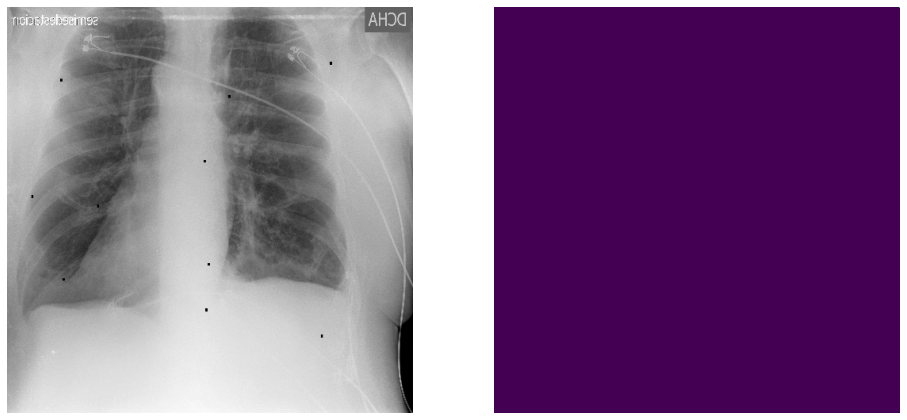

In [ ]:
def draw_sample_dataset(dataset, num):
    image, masked, target, image_id = dataset[num]
    print(dataset[num])
    image = 2 * image[0].numpy() - 1
#     image = image[:, :, 0]
    print('image_max: ', image.max(), ' image_min: ', image.min())
    print('image_shape: ', image.shape)
    print('image_id', image_id)
        
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    ax[0].imshow(image, cmap='gray')
    ax[0].set_axis_off()
    
    ax[1].imshow(masked)
    ax[1].set_axis_off()
    plt.show()


draw_sample_dataset(train_dataset, 1)

# Sample DataLoader

In [ ]:
# # # sample train_loaer
# train_loader = get_train_loader(train_dataset, config['batch_size'])
# valid_loader = get_valid_loader(valid_dataset, config['batch_size'])

In [ ]:
# images, targets, images_id = next(iter(train_loader))
# images = torch.stack(images).float()
# batch_size = images.shape[0]
# # boxes = [target['boxes'].float() for target in targets]
# labels = torch.tensor([target['labels'].numpy() for target in targets])
# targets_input = [{k: v for k, v in t.items()} for t in targets]

# Meter

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class Metrics:
    def __init__(self):
        self._reset()
        
    def _reset(self):
        self.step = 0
        self.batch_sum = 0
        
        self.accuracy_sum = 0
        self.proba_list = []
        self.truth_list = []
        self.auroc_sum = 0
        
        self.accuracy = 0
        self.mAP = 0
        self.AUROC = 0
        
        self.acc = Accuracy().to(device)
        self.AP = AveragePrecision(num_classes=config['num_classes']).to(device)
        self.auroc = AUROC(num_classes=config['num_classes']).to(device)
        
    def update(self, y_true_nd, y_true_1d, y_pred_nd, y_pred_1d, batch_num):
        self.step += 1
        self.batch_num = batch_num
        self.batch_sum += batch_num
        
        self.accuracy_sum += self.acc(y_pred_1d, y_true_1d).item()
        self.accuracy = self.accuracy_sum / self.step
  
        self.proba_list.append(y_pred_nd)
        self.truth_list.append(y_true_1d)
        
    def calculate(self):
        self.proba = torch.cat(self.proba_list)
        self.truth = torch.cat(self.truth_list)
        self.mAP = torch.stack(self.AP(self.proba, self.truth)).mean().item()
        self.AUROC = self.auroc(self.proba, self.truth).item()
    

# Model

In [ ]:
class Effnet(nn.Module):
    def __init__(self, model_name, num_classes=config['num_classes'], pretrained=True):
        super().__init__()
        eff = model_name(pretrained=pretrained, drop_rate=0.3, drop_path_rate=0.2, in_chans=1)
        self.b0 = nn.Sequential(
            eff.conv_stem,
            eff.bn1,
            eff.act1,
        )
        
        self.b1 = eff.blocks[0]
        self.b2 = eff.blocks[1]
        self.b3 = eff.blocks[2]
        self.b4 = eff.blocks[3]
        self.b5 = eff.blocks[4]
        self.b6 = eff.blocks[5]
        self.b7 = eff.blocks[6]
        self.b8 = nn.Sequential(
            eff.conv_head,
            eff.bn2,
            eff.act2,
        )
        self.logit = nn.Linear(2560, num_classes) # effnetb7_ns
        # self.logit = nn.Linear(1280, num_classes) # effnetv2
        
        self.mask = nn.Sequential(
            nn.Conv2d(224, 128, kernel_size=3, padding=1), # effnetb7_ns
            # nn.Conv2d(176, 128, kernel_size=3, padding=1), # effnetv2_m
            nn.BatchNorm2d(128),
            nn.SiLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )
    
#         self.aux_head = nn.Sequential(
#             nn.Conv2d(224, 1344, kernel_size=(1, 1), stride=(1, 1), bias=False), # effnetb7_ns
#             nn.BatchNorm2d(1344, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
#             nn.SiLU(inplace=True),
#         )
#         self.aux_logit = nn.Linear(1344, num_classes)

    def forward(self, x):
        x = 2 * x - 1
        batch_size = len(x)
        
        x = self.b0(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        #------------
#         aux = self.aux_head(x)
#         aux = F.adaptive_avg_pool2d(aux, 1).reshape(batch_size, -1)
#         aux = self.aux_logit(aux)
        aux = self.mask(x)
        #-------------
        x = self.b6(x)
        x = self.b7(x)
        x = self.b8(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        #x = F.dropout(x, 0.5, training=self.training)
        logit = self.logit(x)
        return logit, aux

In [ ]:
def convert_silu_to_mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.SiLU):
            setattr(model, child_name, nn.Mish(inplace=True))
        else:
            convert_silu_to_mish(child)

In [ ]:
def get_model(model_name, checkpoint_path=None):
    model = Effnet(model_name)
    if torch.__version__ == '1.9.0+cu102':
        convert_silu_to_mish(model)
        print('Converted to Mish')
        
    # Load the trained weights
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print('[LOADED MODEL STATE DICT]')
        del checkpoint
        gc.collect()
        
    return model

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs) # fixed for mixed precision
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        # BCE = F.binary_cross_entropy(inputs, targets, reduction='mean') # fixed for mixed precision
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

class LovaszHinge(nn.Module):
    def __init__(self):
        super(LovaszHinge, self).__init__()

    def forward(self, inputs, targets):
        loss = lovasz_hinge(inputs, targets)
        return loss


# Train

In [ ]:
# parameters dacay
# EvalMeter

class Fitter:
    def __init__(self, model, device, config, fold, dry_run=False, wandblogger=False, train_loader_len=None):
        self.model = model
        self.device = device
        self.config = config
        self.fold = fold
        self.wandblogger = wandblogger
        if self.config.accum_grad:
            self.train_loader_len = round(train_loader_len / self.config.accum_iter + 0.1)
        else:
            self.train_loader_len = train_loader_len
        self.remain_time = 0
        self.trained_time = 0
        
        self.dry_run = dry_run
        if self.dry_run == True:
            print('==== DRY RUN ====')
            
        if self.wandblogger and not self.dry_run:
            
            wandb.login(key=self.config.wandb_api)
            wandb.init(project="siim-covid19-detection",
                       name=f'f{self.fold}_{self.config.model_name}',
                       group=f'{self.config.model_name}-{self.config.wandblogger_group}',
                       tags=["study"],
                       save_code=True,
                       resume=True)
        
        self.base_dir = f'./outputs/f{self.fold}_{self.config.model_name}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
            
        self.log_path = f'{self.base_dir}/log.txt'
        self.epoch = 0
        self.best_summary_loss = 10**5
        self.best_score = 0
        self.best_summary_loss_epoch = 0
        self.best_score_epoch = 0
        
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = LabelSmoothingCrossEntropy()
        self.criterion_aux1 = nn.BCEWithLogitsLoss()
        self.criterion_aux2 = LovaszHinge()
        self.criterion_aux3 = DiceBCELoss()
#         self.criterion = self.config.loss_func(**self.config.loss_func_config)

#         self.optimizer = optim.AdamW(self.model.parameters(), lr=self.config.lr, weight_decay=0.001)
#         self.optimizer = optim.SGD(self.model.parameters(), lr=self.config.lr, momentum=0.9, nesterov=True)
        self.optimizer = MADGRAD(self.model.parameters(), lr=self.config.lr)
        # self.optimizer = self.config.optimizer(self.model.parameters(), **self.config.optim_config, num_batches_per_epoch=self.train_loader_len)
        
        if self.config.SchedulerClass == torch.optim.lr_scheduler.OneCycleLR:
            self.config.scheduler_params['steps_per_epoch'] = self.train_loader_len
            self.config.valid_scheduler = False
            self.config.train_scheduler = True
            
        self.scheduler = self.config.SchedulerClass(self.optimizer, **self.config.scheduler_params)
#         if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):


        self._log(f'Train on device: {self.device}')
        self._log('')
        self._log(f'Fold: {self.fold}/{self.config.fold - 1}')
        self._log('')
        self._log(f'Augmentation: {self.config.aug}')
        
        if self.config.model_name != 'undefined':
            self._log('')
            self._log(f'Model: {self.config.model_name}')
        
        self._log('')
        self._log(f'Mixed Precision: {self.config.use_apex}')
        
        if self.config.accum_grad:
            self._log('')
            self._log(f'Gradient Accumulation: {self.config.accum_iter}')
        self._log(f'Batch size: {self.config.batch_size}')
        self.scaler = GradScaler(enabled=self.config.use_apex)
        
        self._log('')
        self._log(f'Optimizer: {self.optimizer}')
        self._log(f'LR Scheduler (Valid: {self.config.valid_scheduler}, Train: {self.config.train_scheduler}):\n{self.scheduler}')
        self._log(f'{self.config.scheduler_params}')
        
        self._log('')
        self._log(f'Loss: {self.criterion} + ({self.criterion_aux1} + {self.criterion_aux2} + {self.criterion_aux3})')
        # self._log(f'Loss: {self.criterion} + ({self.criterion_aux1} + {self.criterion_aux2})')
        
    def fit(self, train_loader, validation_loader):
        for epoch in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self._log(f'\n{timestamp}\nLR: {lr}')
                
            t = time.time()
            train_loss, train_aux_loss, train_metrics = self._train_one_epoch(train_loader)
            
            if epoch == 0:
                self.best_summary_loss = train_loss.avg
                
            train_time = time.time() - t
            self._log(f'[RESULT]: Train. Epoch: {self.epoch + 1}/{self.config.n_epochs}, ' + \
                      f'summary_loss: {train_loss.avg:.5f}, ' + \
                      f'aux_loss: {train_aux_loss.avg:.5f}, ' + \
                      f'acc: {train_metrics.accuracy:.5f}, ' + \
                      f'mAP: {train_metrics.mAP:.5f}, ' + \
                      f'AUROC: {train_metrics.AUROC:.5f}, ' + \
                      f'time: {train_time:.5f}')
            self._save(f'{self.base_dir}/last-checkpoint.pth', last=True)
            
            t = time.time()
            valid_loss, valid_metrics = self._validation(validation_loader)
            
            valid_time = time.time() - t
            self._log(f'[RESULT]: Valid. Epoch: {self.epoch + 1}/{self.config.n_epochs}, ' + \
                      f'summary_loss: {valid_loss.avg:.5f}, ' + \
                      f'acc: {valid_metrics.accuracy:.5f}, ' + \
                      f'mAP: {valid_metrics.mAP:.5f}, ' + \
                      f'AUROC: {valid_metrics.AUROC:.5f}, ' + \
                      f'time: {valid_time:.5f}')
        
            
            if self.wandblogger and not self.dry_run:
                wandb.log({"train/loss": train_loss.avg,
                           "train/aux_loss": train_aux_loss.avg,
                           "train/lr": lr,
                           "val/loss": valid_loss.avg,
                           "metrics/mAP": valid_metrics.mAP,
                           "metrics/acc": valid_metrics.accuracy,
                           "metrics/AUROC": valid_metrics.AUROC,
                           })
                
        
            if valid_loss.avg < self.best_summary_loss:
                self.best_summary_loss = valid_loss.avg
                self.best_summary_loss_epoch = self.epoch
                self.model.eval()
                self._save(f'{self.base_dir}/best-loss.pth')
                self._log(f'[SAVED] Epoch: {self.epoch + 1} best-loss: {self.best_summary_loss:.5f}')
                    
            if valid_metrics.mAP > self.best_score:
                self.best_score = valid_metrics.mAP
                self.best_score_epoch = self.epoch
                self.model.eval()
                self._save(f'{self.base_dir}/best-score.pth')
                self._log(f'[SAVED] Epoch: {self.epoch + 1} best-score: {self.best_score:.5f}')
            
            if self.config.valid_scheduler:
                # self.scheduler.step(metrics=valid_loss.avg)
                self.scheduler.step()
            
            self.epoch += 1
            
            mins_per_epoch = (train_time + valid_time)
            total_time_hrs = (mins_per_epoch * (self.config.n_epochs))
            
            self.trained_time += mins_per_epoch
            self.remain_time = total_time_hrs - self.trained_time
            
            self._log(f'[TIME]: Trained: {timedelta(seconds=self.trained_time)}, ETA: {timedelta(seconds=self.remain_time)}')
            
            # for test
            if self.dry_run:
                if self.epoch == 1:
                    break
            gc.collect()        
            torch.cuda.empty_cache()
            
        self._log('')
        self._log(f'[BEST LOSS] {self.best_summary_loss:.5f} at epoch {self.best_summary_loss_epoch + 1}')
        self._log(f'[BEST SCORE] {self.best_score:.5f} at epoch {self.best_score_epoch + 1} ')
            
    def _validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        metrics = Metrics()
        
        t = time.time()
        for step, (images, masked, targets, imaage_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step + 1}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'acc: {metrics.accuracy:.5f} ' + \
                        f'time: {(time.time() - t):.5f}, ' + \
                        f'[{(step + 1)/(time.time() - t):.2f}it/s]', end='\r'
                        )
                    
            with torch.no_grad():
                images = torch.stack(images).to(self.device).float()
                batch_size = images.shape[0]
                labels = torch.stack([target['labels'] for target in targets]).to(self.device).float()
                
                outputs, aux_outputs = self.model(images)
                
                loss = self.criterion(outputs, torch.max(labels, 1)[1])
                                    
            summary_loss.update(loss.detach().item(), batch_size)
            
            probability = F.softmax(outputs)
            
            true_labels_1d = torch.max(labels, 1)[1]
            pred_labels_1d = torch.max(probability, 1)[1]            
            
            metrics.update(y_true_nd = labels.detach(),
                           y_true_1d = true_labels_1d.detach(),
                           y_pred_nd = probability.detach(),
                           y_pred_1d = pred_labels_1d.detach(),
                           batch_num = batch_size)

            # for test  
            if self.dry_run:
                if step == 0:
                    break
        
        if not self.dry_run:
            metrics.calculate()
                    
        return summary_loss, metrics
    
    def _train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        summary_aux_loss = AverageMeter()
        metrics = Metrics()
        
        t = time.time()
        
        for step, (images, masked, targets, image_ids) in enumerate(train_loader):
            target_res = {}
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step + 1}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'aux_loss: {summary_aux_loss.avg:.5f}, ' + \
                        f'acc: {metrics.accuracy:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}, ' + \
                        f'[{(step + 1)/(time.time() - t):.2f}it/s]'
                        )
            images = torch.stack(images).to(self.device).float()
            masked = torch.unsqueeze(torch.stack(masked), dim=1).to(self.device).float()
            masked = F.interpolate(masked, size=(self.config.masked_size, self.config.masked_size), mode='bilinear', align_corners=False)
            batch_size = images.shape[0]
            labels = torch.stack([target['labels'] for target in targets]).to(self.device).float()

            with autocast(enabled=self.config.use_apex):
                outputs, aux_outputs = self.model(images)
                loss = self.criterion(outputs, torch.max(labels, 1)[1])
#                 aux_loss = self.criterion_aux(aux_outputs, masked)
                aux_loss1 = self.criterion_aux1(aux_outputs, masked) # aux1=bce
                aux_loss2 = self.criterion_aux2(aux_outputs, masked) # aux2=lovasz
                aux_loss3 = self.criterion_aux3(aux_outputs, masked) # aux3=dice_bce
            aux_loss = (0.2 * aux_loss1) + (0.7 * aux_loss2) + (0.1 * aux_loss3)
            # aux_loss = (0.25 * aux_loss1) + (0.75 * aux_loss2) #+ (0.1 * aux_loss3)
            
            if self.config.accum_grad: 
                loss = loss / self.config.accum_iter
                aux_loss = aux_loss / self.config.accum_iter
                self.scaler.scale(loss + aux_loss).backward()

                if ((step + 1) % self.config.accum_iter == 0) or (step + 1 == len(train_loader)):
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    if self.config.train_scheduler:
                        if self.config.SchedulerClass == optim.lr_scheduler.CosineAnnealingWarmRestarts:
                            self.scheduler.step(self.epoch + step / len(train_loader))
                        else:
                            self.scheduler.step()
                    self.optimizer.zero_grad(set_to_none=True)
                    
                    summary_loss.update(loss.detach().item() * self.config.accum_iter, batch_size)
                    summary_aux_loss.update(aux_loss.detach().item() * self.config.accum_iter, batch_size)
                
                    probability = F.softmax(outputs)
                
                    true_labels_1d = torch.max(labels, 1)[1]
                    pred_labels_1d = torch.max(probability, 1)[1]            
                
                    metrics.update(y_true_nd = labels.detach(),
                           y_true_1d = true_labels_1d.detach(),
                           y_pred_nd = probability.detach(),
                           y_pred_1d = pred_labels_1d.detach(),
                           batch_num = batch_size)
            else:
                self.scaler.scale(loss + aux_loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)
                
                summary_loss.update(loss.detach().item(), batch_size)
                summary_aux_loss.update(aux_loss.detach().item(), batch_size)
            
                probability = F.softmax(outputs)
            
                true_labels_1d = torch.max(labels, 1)[1]
                pred_labels_1d = torch.max(probability, 1)[1]            
            
                metrics.update(y_true_nd = labels.detach(),
                           y_true_1d = true_labels_1d.detach(),
                           y_pred_nd = probability.detach(),
                           y_pred_1d = pred_labels_1d.detach(),
                           batch_num = batch_size)
            
            # for test
            if self.dry_run:
                if step == 0:
                    break
        if not self.dry_run:
            metrics.calculate()
                    
        return summary_loss, summary_aux_loss, metrics
    
    def _save(self, path, last=False):
        self.model.eval()
        if last:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
    #             'schedular_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'best_score': self.best_score,
                'epoch': self.epoch,
            }, path)
        else:
            torch.save({
                'model_state_dict': self.model.state_dict(),
    #             'optimizer_state_dict': self.optimizer.state_dict(),
    #             'schedular_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'best_score': self.best_score,
                'epoch': self.epoch,
            }, path)
        

            
    def load(self, path, last=False):
        checkpoint = torch.load(path, map_location=self.device)
        if last:
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.best_summary_loss = checkpoint['best_summary_loss']
            self.best_score = checkpoint['best_score']
#             self.epoch = checkpoint['epoch']
        else:
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.best_summary_loss = checkpoint['best_summary_loss']
            self.best_score = checkpoint['best_score']
#             self.epoch = checkpoint['epoch']
        self._log('[LOADED STATE DICT]')
    
    def _log(self, message):
        print(message)
        with open(self.log_path,'a+') as logger:
            logger.write(f'{message}\n') 

In [ ]:
class TrainConfig:
    num_workers = config['num_workers']
    batch_size = config['batch_size']
    n_epochs = 15
    lr = 0.001
    # can set lower than this on resume-model
    fold = config['fold']
    aug =  str(get_train_transforms())
    verbose = True
    verbose_step = 100
    
    model_name = 'undefined'
    wandblogger_group = 'undefined'
    
    wandb_api = '3b4a4f9e3a49edd10367fc27bad65a138866678d'
    
    valid_scheduler = False
    train_scheduler = True
    use_apex = True
    
    accum_grad = True
    accum_iter = 8
    
    masked_size = 32
    
#     SchedulerClass = optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=3,
#         verbose=False,
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0,
#         min_lr=1e-6,
#         eps=1e-08
#     )
    
    SchedulerClass = optim.lr_scheduler.CosineAnnealingWarmRestarts
    scheduler_params = dict(
        T_0=5,
        T_mult=2,
        eta_min=0.0001,
        last_epoch=-1,
        verbose=False
    
    )

    # SchedulerClass = optim.lr_scheduler.StepLR
    # scheduler_params = dict(
    #     step_size=15,
    #     gamma=0.1
    # )
    
    # SchedulerClass = optim.lr_scheduler.OneCycleLR
    # scheduler_params = dict(
    #     max_lr=lr,
    #     steps_per_epoch=0,
    #     epochs=n_epochs
    # )
    
    optimizer = Ranger21
    optim_config = dict(
        lr=lr,
        lookahead_active=True,
        use_madgrad=True,
#         weight_decay=0,
        using_gc=True,
        using_normgc=True,
        normloss_active=True,
        softplus=True,
        use_adaptive_gradient_clipping=True,
        num_epochs=n_epochs,
        warmdown_active=True,
        
    )

In [ ]:
TrainConfig.model_name = 'effnetb7_ns'
# TrainConfig.model_name = 'effnetv2_m21'

unique_group_id = wandb.util.generate_id()
# TrainConfig.wandblogger_group = unique_group_id
TrainConfig.wandblogger_group = 'exp2'

def run_training(dry_run=False, wandblogger=True):
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    
#     for fold in range(config['fold']):
    fold = 0
    net = get_model(model_name=tf_efficientnet_b7_ns, checkpoint_path=None)
    net.to(device)
    
    train_dataset = get_train_dataset(fold)
    valid_dataset = get_valid_dataset(fold)
    
    config['batch_size'] = 4 # 4x8
    
#     if dry_run:
#         config['batch_size'] = 2
    
    train_loader = get_train_loader(train_dataset, config['batch_size'])
    valid_loader = get_valid_loader(valid_dataset, config['batch_size'])
    
    train_loader_len = len(train_loader)
    
    fitter = Fitter(model=net, device=device, config=TrainConfig, fold=fold, dry_run=dry_run, wandblogger=wandblogger, train_loader_len=train_loader_len)
    # fitter.load(path='/content/outputs/f0_effnetv2_m21/last-checkpoint.pth', last=True)
    fitter.fit(train_loader, valid_loader)

In [ ]:
# if os.path.exists('/content/outputs') or os.path.exists('/content/wandb'):
#     torch.cuda.empty_cache()
#     !rm -rf /content/outputs
#     !rm -rf /content/wandb
#     print('Deleted previous outputs')

In [ ]:
run_training(dry_run=False, wandblogger=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b7_ns-1dbc32de.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b7_ns-1dbc32de.pth


Converted to Mish


wandb: Currently logged in as: sunpnwt (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on device: cuda:0

Fold: 0/4

Augmentation: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(0, 0), shift_limit_y=(0, 0), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-6, 6), interpolation=1, border_mode=4, value=None, mask_value=None),
  RandomResizedCrop(always_apply=False, p=0.5, height=512, width=512, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
  Cutout(always_apply=False, p=0.5, num_holes=10, max_h_size=16, max_w_size=16),
  RandomGamma(always_apply=False, p=0.5, gamma_limit=(95, 105), eps=None),
  RandomBrightness(always_apply=False, p=0.5, limit=(-0.2, 0.2)),
  Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

Model: effnetb7_ns

Mixed Precision: True

Gradient Accumulation: 8
Batch size: 4

Optimiz

KeyboardInterrupt: ignored

In [ ]:
wandb.finish()

train/loss,0.8868
train/aux_loss,0.75662
train/lr,0.00019
val/loss,1.01955
metrics/mAP,0.53021
metrics/acc,0.66137
metrics/AUROC,0.79005
_runtime,10539
_timestamp,1628023670
_step,13


train/loss,█▅▄▃▂▅▄▅▄▃▃▂▂▁
train/aux_loss,█▅▄▃▂▄▃▃▂▂▂▂▂▁
train/lr,█▇▆▃▂▁█▇▇▆▅▃▂▂
val/loss,▆▄▂▁▂██▄▆▂▅▄▃▅
metrics/mAP,▁▄▇██▂▅▅▆▇▇▇█▇
metrics/acc,▄▅▇█▆▂▁▅▅█▅▇█▇
metrics/AUROC,▁▅▇█▇▃▄▅▆▇▆▆▆▆
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


In [ ]:
import shutil
shutil.copytree(f'/content/outputs/f0_{TrainConfig.model_name}', f'/content/drive/MyDrive/kaggle/siim-covid19-detection/f0_{TrainConfig.model_name}')
print('==== Copied to GDrive =====') 

==== Copied to GDrive =====
